In [ ]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


# Assignment - Biomarker Identification and Data Processing

## Biomarker identification -- Mirdametinib

In the lecture we tried to go through the genomic features that could be associated with EGFR inhibitor. In this exercise, we will follow the steps in the [Barretina _et al._](https://www.nature.com/articles/nature11003) paper to investigate Mirdametinib, a [MEK](https://en.wikipedia.org/wiki/Mitogen-activated_protein_kinase_kinase) inhibitor.


Files needed are found here:

[CCLE_NP24.2009_Drug_data_2015.02.24.csv](https://drive.google.com/open?id=1EZw-2tT2Zl8gbC_nFWGTp0bm9DjZFoFu): the activity data for  24 anti-cancer drugs in 504 cell lines

[CCLE_DepMap_18q3_maf_20180718.txt](https://drive.google.com/open?id=1L2aY17s5xjtNythWVBi9oKNSA50VhVeD): mutation data for the cell lines

[celllines_rnaseq_voom.txt](https://drive.google.com/open?id=1oAFOu1lQnTTbwcBSYcThTuNCQsgO53-7): voom-normalized gene expression data for the cell lines


First, drug activity data from CCLE is loaded and drug sensitivity data screened by the MEK inhibitor in question is parsed. At the time when the data set was published, it is still using the lab name `PD-0325901`. Also, only the drug data which has good sigmoid fit (`FitType == "Sigmoid"`) is selected.

In [ ]:
# Set data file location
# If you are running notebooks on your laptop, change this to the directory
# where you put downloaded files

from pathlib import Path

DATA = Path("/content/drive/My Drive/Colab Notebooks/")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#==========================================================================
# Load CCLE drug data and get the drug sensitivity data from the PD-0325901
# compound and select only the rows where FitType is Sigmoid
#==========================================================================

pharm = pd.read_csv(DATA / "CCLE_NP24.2009_Drug_data_2015.02.24.csv")
pharm.head()

,CCLE Cell Line Name,Primary Cell Line Name,Compound,Target,Doses (uM),Activity Data (median),Activity SD,Num Data,FitType,EC50 (uM),IC50 (uM),Amax,ActArea
0,1321N1_CENTRAL_NERVOUS_SYSTEM,1321N1,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8","8.67,11.0,2.16,.27,-10,-13,-26,-43","3.31,3.72,5.36,4.67,13.1,.18,2.42,7.51",8,Sigmoid,8.717774,8.000000,-42.558014,0.7124
1,22RV1_PROSTATE,22Rv1,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8",".94,12.5,-14,4.16,-25,-32,-52,-71","1.95,13.3,6.98,21.8,16.0,18.8,4.84,7.93",8,Sigmoid,8.165164,2.329924,-71.589340,1.6723
2,42MGBA_CENTRAL_NERVOUS_SYSTEM,42-MG-BA,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8","8.91,8.39,-3.5,12.4,-.55,-6.2,-48,-63","13.7,7.70,11.1,6.43,24.0,9.57,9.57,10.4",8,Sigmoid,1.514508,2.682130,-63.491371,1.1852
3,5637_URINARY_TRACT,5637,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8","2.15,9.91,-3.5,.056,-2.1,-14,-30,-62","4.05,9.75,12.7,4.36,11.0,10.0,24.6,.14",8,Sigmoid,8.006595,5.002314,-62.352776,0.9948
4,639V_URINARY_TRACT,639-V,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8","11.8,-7.3,-9.4,-15,-11,-21,-53,-50",".95,5.67,11.1,.68,31.6,22.3,1.45,3.08",8,Sigmoid,0.931196,1.736181,-51.959808,1.5436


In [ ]:
pharm.shape

(11670, 13)

In [ ]:
pharmPD = pharm[pharm.Compound.eq("PD-0325901")]
pharmPD.shape

(504, 13)

In [ ]:
phPDSig = pharmPD[pharmPD.FitType.eq("Sigmoid")]
phPDSig.head()

,CCLE Cell Line Name,Primary Cell Line Name,Compound,Target,Doses (uM),Activity Data (median),Activity SD,Num Data,FitType,EC50 (uM),IC50 (uM),Amax,ActArea
7259,1321N1_CENTRAL_NERVOUS_SYSTEM,1321N1,PD-0325901,MEK,".0025,.0080,.025,.080,.25,.80,2.53,8","7.14,4.24,2.51,-5.2,-5.6,-18,-31,-46","6.44,11.4,1.65,4.37,6.82,9.97,8.83,1.46",8,Sigmoid,8.324544,8.00000,-46.594528,0.6516
7260,22RV1_PROSTATE,22Rv1,PD-0325901,MEK,".0025,.0080,.025,.080,.25,.80,2.53,8","-20,-31,-41,-36,-41,-46,-54,-39","7.82,.24,6.63,4.47,3.64,2.97,.34,6.74",8,Sigmoid,0.002543,8.00000,-46.052967,2.8355
7261,42MGBA_CENTRAL_NERVOUS_SYSTEM,42-MG-BA,PD-0325901,MEK,".0025,.0080,.025,.080,.25,.80,2.53,8","20.1,-7.0,2.31,-19,-2.2,-15,-25,-62","7.25,23.3,4.56,29.2,9.68,17.3,7.15,10.7",8,Sigmoid,8.754744,5.87059,-59.114983,1.2940
7262,5637_URINARY_TRACT,5637,PD-0325901,MEK,".0025,.0080,.025,.080,.25,.80,2.53,8","7.39,-6.0,4.96,-18,-17,-26,-30,-52","17.8,10.7,13.8,8.69,15.5,2.81,9.15,8.11",8,Sigmoid,8.767333,8.00000,-49.223431,0.9413
7263,639V_URINARY_TRACT,639-V,PD-0325901,MEK,".0025,.0080,.025,.080,.25,.80,2.53,8","-8.1,-18,-17,-36,-38,-35,-47,-48","1.08,13.1,5.72,1.50,5.64,8.30,2.36,5.12",8,Sigmoid,0.032920,8.00000,-47.029522,2.2210


In [ ]:
phPDSig.shape

(368, 13)


#### 1.1 By selecting `FitType == "Sigmoid"`, how many cell lines have sigmoid-fitted sensitivity data from `PD-0325901`?

There are 368 cell lines that have sigmoid-fitted sensitivity data from the drug PD-0325901.

### Calculate association between MAP2K1/2 mutation and MEK inhibitor

Similar to lecture, I will first investigate the correlation between `PD-0325901` activity and its target genes: `MEK1` (`MAP2K1`) and `MEK2` (`MAP2K2`). For simplicity, only mutations that are either missense mutations or LoF (`missense_lof`) will be analyzed.

First, the cell lines that has at least one missense or LoF mutation in `MAP2K1` or `MAP2K2` gene are identified. Then, a boxplot of active area (`ActArea`) between these cell lines and the other cell lines is generated. Finally, a 2-sided Mann-Whitney U test (`alternative="two_sided"`) is implemented to see if the difference is statistically significant.

In [ ]:
#=============================================================================
# Identify the cell lines containing at least one COSMIC hotspot mutation in 
# either MAP2K1 gene or MAP2K2 gene. Do a boxplot showing the ActArea
# distribution of these two groups and use Mann-Whitney U test to check for
# statistical significance between the two groups.
#=============================================================================

maf = pd.read_csv(DATA / "CCLE_DepMap_18q3_maf_20180718.txt", sep="\t")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,25,26,27,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
maf.head()

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,dbSNP_RS,dbSNP_Val_Status,Genome_Change,Annotation_Transcript,Tumor_Sample_Barcode,cDNA_Change,Codon_Change,Protein_Change,isDeleterious,isTCGAhotspot,TCGAhsCnt,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Broad_ID
0,DVL1,1855,37,1,1277461,1277461,+,Silent,SNP,C,T,NaN,NaN,g.chr1:1277461C>T,ENST00000378888.5,127399_SOFT_TISSUE,c.438G>A,c.(436-438)gaG>gaA,p.E146E,False,False,0,False,0,NaN,87:39,NaN,NaN,NaN,NaN,NaN,NaN,ACH-001270
1,AL590822.1,0,37,1,2144416,2144416,+,Missense_Mutation,SNP,G,A,NaN,NaN,g.chr1:2144416G>A,ENST00000545087.1,127399_SOFT_TISSUE,c.604C>T,c.(604-606)Cgc>Tgc,p.R202C,False,False,0,False,0,NaN,23:43,NaN,NaN,NaN,NaN,NaN,NaN,ACH-001270
2,PLCH2,9651,37,1,2435359,2435359,+,Splice_Site,SNP,A,C,NaN,NaN,g.chr1:2435359A>C,ENST00000419816.2,127399_SOFT_TISSUE,NaN,c.e22-1,NaN,True,False,0,False,0,NaN,9:25,NaN,NaN,NaN,NaN,NaN,NaN,ACH-001270
3,UBE4B,10277,37,1,10177641,10177641,+,Missense_Mutation,SNP,G,A,NaN,NaN,g.chr1:10177641G>A,ENST00000253251.8,127399_SOFT_TISSUE,c.934G>A,c.(934-936)Gaa>Aaa,p.E312K,False,False,0,False,0,NaN,13:95,NaN,NaN,NaN,NaN,NaN,NaN,ACH-001270
4,SRM,6723,37,1,11119363,11119363,+,Silent,SNP,G,T,rs34097618,NaN,g.chr1:11119363G>T,ENST00000376957.2,127399_SOFT_TISSUE,c.207C>A,c.(205-207)atC>atA,p.I69I,False,False,0,False,0,NaN,113:57,NaN,NaN,NaN,NaN,NaN,NaN,ACH-001270


In [ ]:
maf.isCOSMIChotspot.sum()
# Total number of TRUE isCOSMIChotspots

3831

In [ ]:
maf.Variant_Classification.unique()

array(['Silent', 'Missense_Mutation', 'Splice_Site', 'Nonsense_Mutation',
       'De_novo_Start_OutOfFrame', 'Start_Codon_SNP', 'Nonstop_Mutation',
       'Frame_Shift_Del', 'Frame_Shift_Ins', 'In_Frame_Del',
       'In_Frame_Ins', 'Stop_Codon_Del', 'Stop_Codon_Ins',
       'Start_Codon_Del', 'Start_Codon_Ins', "5'Flank", 'Intron', 'IGR',
       "3'UTR", "5'UTR"], dtype=object)

In [ ]:
maf["LOF"] = maf.Variant_Classification.isin(
    {"Nonsense_Mutation", 'Frame_Shift_Del', 'Frame_Shift_Ins',
     'Stop_Codon_Ins', 'Start_Codon_Del', "Splice_Site"}
)

maf["missense_lof"] = maf.Variant_Classification.isin(
    {"Missense_Mutation", 'Stop_Codon_Del', 'Start_Codon_Ins',
     "Nonstop_Mutation", 'In_Frame_Del', 'In_Frame_Ins',}
) | maf.LOF

In [ ]:
print(maf.Hugo_Symbol.value_counts().MAP2K1)
print(maf.Hugo_Symbol.value_counts().MAP2K2)

50
48


In [ ]:
map2k = maf[((maf.Hugo_Symbol == "MAP2K1") | (maf.Hugo_Symbol == "MAP2K2")) &
           (maf.LOF | maf.missense_lof | maf.isCOSMIChotspot)]
           
map2k = map2k.groupby("Tumor_Sample_Barcode")[
    ["LOF", "missense_lof", "isCOSMIChotspot"]
].sum().astype(bool)

In [ ]:
map2k.shape

(66, 3)

In [ ]:
map2k.isCOSMIChotspot.sum()

1

In [ ]:
pharm_map2k = pharm.loc[(pharm.Compound == "PD-0325901") & (pharm.FitType == "Sigmoid"),
                       ["CCLE Cell Line Name", "ActArea"]].copy()
# create a new column indicating MAP2k mutation status
pharm_map2k = pharm_map2k.merge(
    map2k,
    left_on="CCLE Cell Line Name", right_index=True, how="left"
).fillna(False)

In [ ]:
pharm_map2k.head()

,CCLE Cell Line Name,ActArea,LOF,missense_lof,isCOSMIChotspot
7259,1321N1_CENTRAL_NERVOUS_SYSTEM,0.6516,False,False,False
7260,22RV1_PROSTATE,2.8355,False,False,False
7261,42MGBA_CENTRAL_NERVOUS_SYSTEM,1.2940,False,False,False
7262,5637_URINARY_TRACT,0.9413,False,False,False
7263,639V_URINARY_TRACT,2.2210,False,True,False


In [ ]:
pharm_map2k.isCOSMIChotspot.sum()
# Indicating that there is ONLY ONE TRUE VALUE FOR isCOSMIChotspot

1

In [ ]:
import seaborn as sns
from scipy.stats import mannwhitneyu

In [ ]:
pharm_map2k.head()

,CCLE Cell Line Name,ActArea,LOF,missense_lof,isCOSMIChotspot
7259,1321N1_CENTRAL_NERVOUS_SYSTEM,0.6516,False,False,False
7260,22RV1_PROSTATE,2.8355,False,False,False
7261,42MGBA_CENTRAL_NERVOUS_SYSTEM,1.2940,False,False,False
7262,5637_URINARY_TRACT,0.9413,False,False,False
7263,639V_URINARY_TRACT,2.2210,False,True,False


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 15.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 14.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


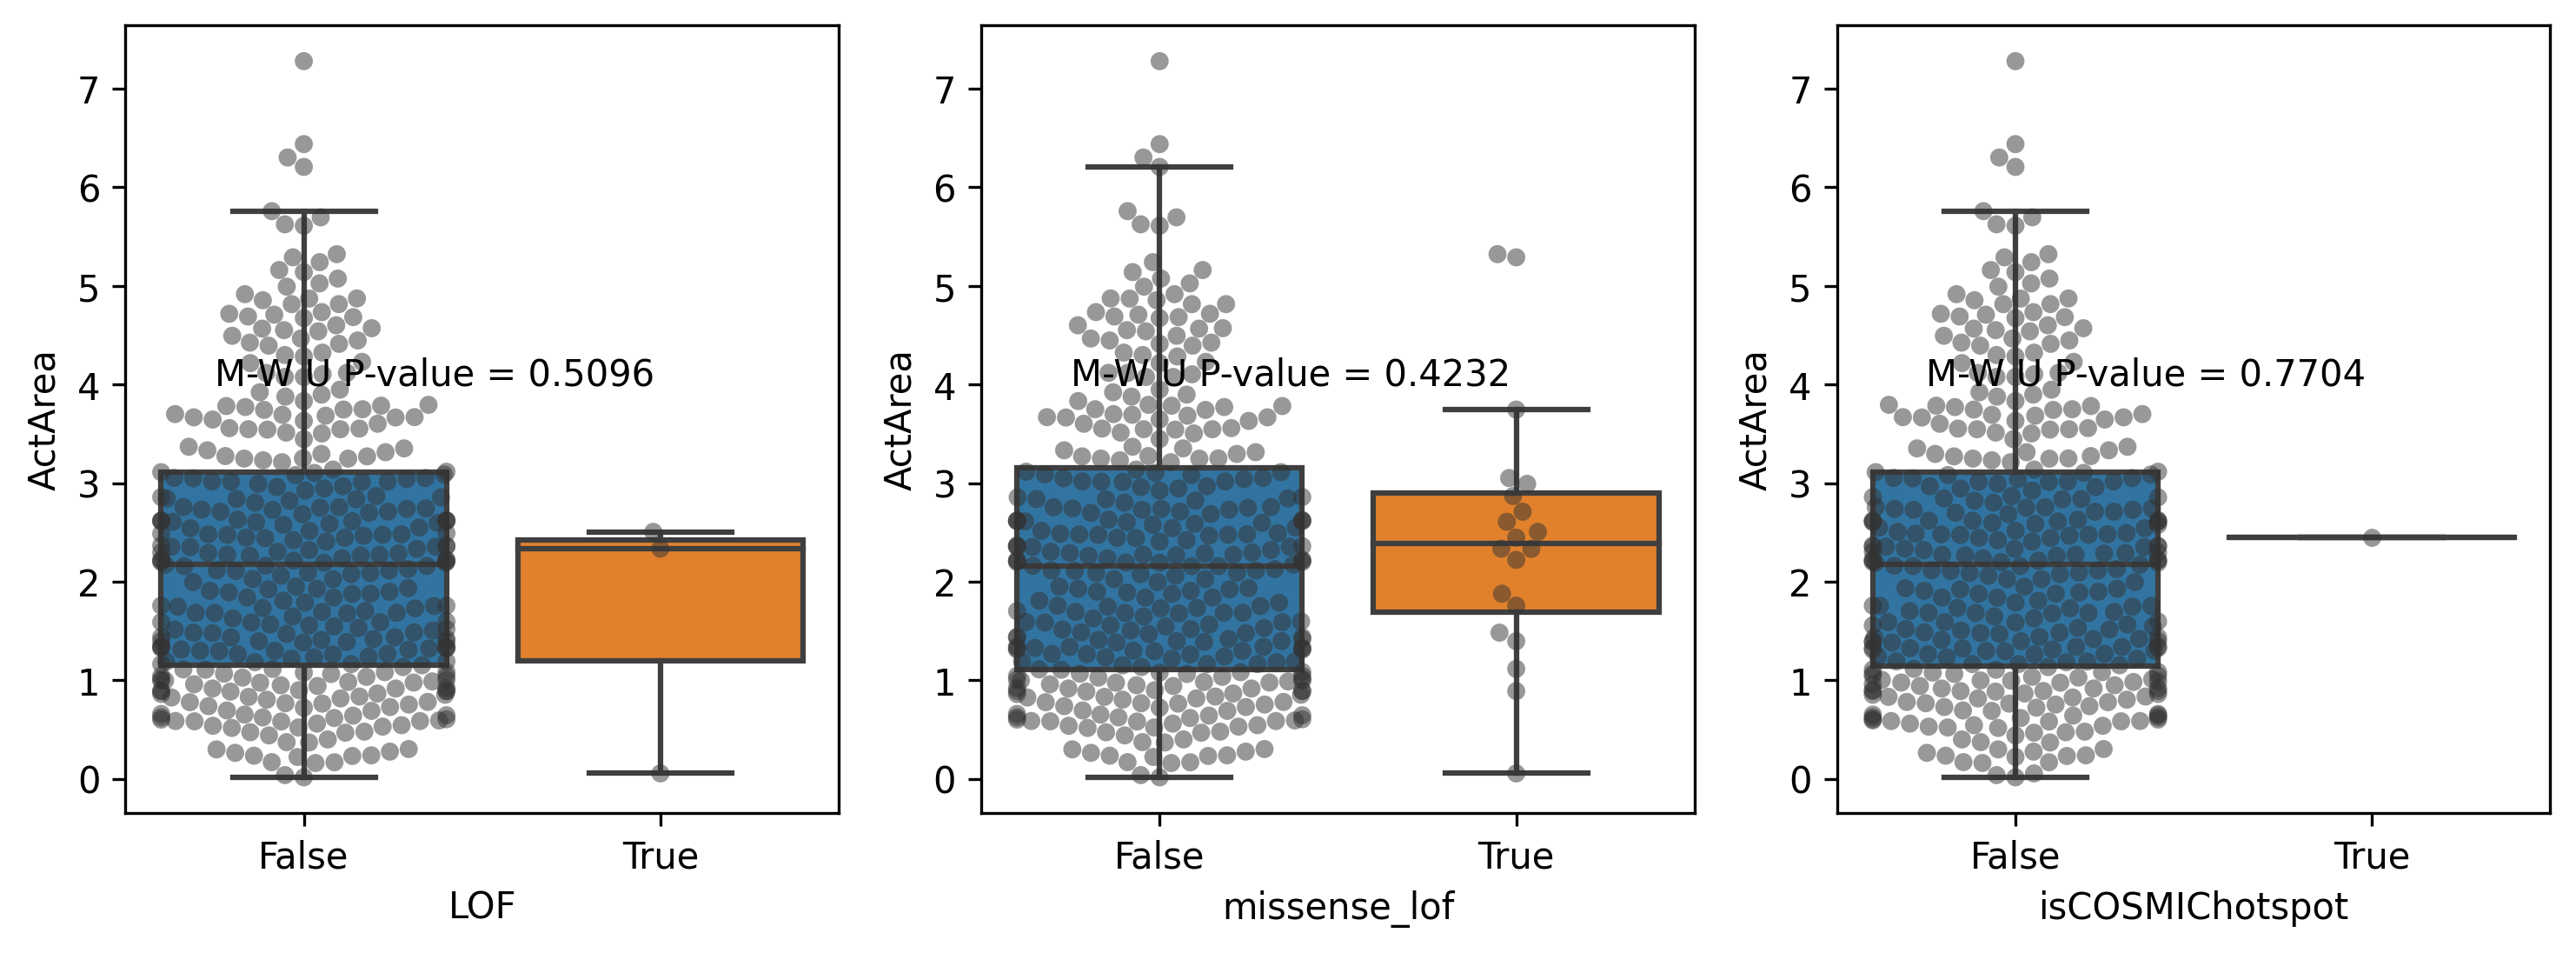

In [ ]:
fig, axarr = plt.subplots(1, 3, dpi=300, figsize=(12, 4))
for idx, col in enumerate(["LOF", "missense_lof", "isCOSMIChotspot"]):
    ax = axarr[idx]
    mwu, pval = mannwhitneyu(pharm_map2k.loc[pharm_map2k[col], "ActArea"],
                            pharm_map2k.loc[~pharm_map2k[col], "ActArea"],
                            alternative="two-sided")
    sns.boxplot(x=col, y="ActArea", data=pharm_map2k, fliersize=0, ax=ax)
    sns.swarmplot(x=col, y="ActArea", data=pharm_map2k, color=".2",
                  alpha=0.5, ax=ax)
    ax.text(-0.25, 4, "M-W U P-value = {}".format(np.round(pval, 4)))

Based on the boxplots, I do not notice a large difference in ActArea between the LOF and the missense LOF groups (the isCOSMIChotspot group did not have many TRUE values at all) in which there does not exist a mutation (the FALSE groups). However, in the TRUE, the missense_LOF group observes a larger group in ActArea (as there are more mutations than just LOF). However, the range between the two groups is still somewhat overlapping mostly. 

Now I will try to identify other predictive features for Mirdametinib. Following the lecture note, combining gene expression data and mutation data of the cell lines. Similar to lecture, I will only include mutations that have been observed frequently in the COSMIC database (`isCOSMIChotspot` is `True`)

In [ ]:
#===========================================================================
# Create a feature matrix containing gene expression data and COSMIC hotspot
# mutations
#===========================================================================
maf_nn = maf[maf.isCOSMIChotspot]

mut_mat = maf_nn.pivot_table(index="Hugo_Symbol", columns="Tumor_Sample_Barcode", values="Start_position",
                             aggfunc=len, fill_value=0)

# change the index name to indicate it's mutation, distinguishing them from expression
mut_mat.index = mut_mat.index.to_series() + "_mut"

mut_mat.head()

Tumor_Sample_Barcode,201T_LUNG,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,451LU_SKIN,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,786O_KIDNEY,8305C_THYROID,8505C_THYROID,8MGBA_CENTRAL_NERVOUS_SYSTEM,A101D_SKIN,A1207_CENTRAL_NERVOUS_SYSTEM,A172_CENTRAL_NERVOUS_SYSTEM,A2058_SKIN,A253_SALIVARY_GLAND,A2780_OVARY,A375_SKIN,A388_SKIN,A427_LUNG,A431_SKIN,A498_KIDNEY,A4FUK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,A549_LUNG,A673_BONE,A704_KIDNEY,ABC1_LUNG,ACCMESO1_PLEURA,ACCS_URINARY_TRACT,ACHN_KIDNEY,ACN_AUTONOMIC_GANGLIA,AGS_STOMACH,ALLPO_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,AM38_CENTRAL_NERVOUS_SYSTEM,...,UMUC6_URINARY_TRACT,UOK101_KIDNEY,UPCISCC152_UPPER_AERODIGESTIVE_TRACT,UT7_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,UW228_CENTRAL_NERVOUS_SYSTEM,UWB1289_OVARY,VAESBJ_SOFT_TISSUE,VAL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,VCAP_PROSTATE,VMCUB1_URINARY_TRACT,VMRCLCD_LUNG,VMRCLCP_LUNG,VMRCMELG_SKIN,VMRCRCW_KIDNEY,VMRCRCZ_KIDNEY,WIL2NS_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,WM115_SKIN,WM1552C_SKIN,WM1799_SKIN,WM2664_SKIN,WM278_SKIN,WM35_SKIN,WM793_SKIN,WM88_SKIN,WM983B_SKIN,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,WSUNHL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Y79_AUTONOMIC_GANGLIA,YAMATO_SOFT_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,YMB1E_BREAST,YT_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ZR751_BREAST,ZR7530_BREAST
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ABCC4_mut,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AKT1_mut,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ALK_mut,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AMER1_mut,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
APC_mut,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Next, similar to lecture, I will subset my feature matrix (gene expression + mutation) to only the cell lines that has `ActArea` values from `PD-0325901`, then fit it to the `SelectFromModel` feature selector with `RandomForestRegressor` estimator.

In [ ]:
#===========================================================================
# Create a subset of the feature matrix with only cell lines that have the
# ActArea values of PD-0325901. 
#===========================================================================
from io import StringIO
import requests

# This is the link to get all the genes with approved-symbol from HGNC
hgnc_link = "https://www.genenames.org/cgi-bin/download?col=gd_app_sym&col=gd_pub_ensembl_id&status=Approved&status=Entry+Withdrawn&status_opt=2&where=&order_by=gd_app_sym_sort&format=text&limit=&hgnc_dbtag=on&submit=submit"
gene_sym_link = requests.get(hgnc_link)
gene_sym = pd.read_table(StringIO(gene_sym_link.text))

gene_sym.head()


,Approved symbol,Ensembl gene ID
0,A1BG,ENSG00000121410
1,A1BG-AS1,ENSG00000268895
2,A1CF,ENSG00000148584
3,A1S9T,NaN
4,A2M,ENSG00000175899


In [ ]:
ge = pd.read_csv(DATA / "celllines_rnaseq_voom.txt", index_col = 0, sep="\t")

In [ ]:
ge_ = ge.loc[ge.index.to_series().isin(gene_sym["Approved symbol"]), :]

# combine expression and mutation matrix, note we use inner join so we get the intersection of the samples
feat = pd.concat([ge_, mut_mat], axis=0, join="inner").fillna(0)

feat.shape

(18868, 1005)

In [ ]:
# get overlap between feature matrix and the ActArea
ovlp_index = pharm_map2k["CCLE Cell Line Name"].isin(feat.columns.values)
ovlp_celllines = pharm_map2k.loc[ovlp_index, "CCLE Cell Line Name"]

In [ ]:
feat = feat.loc[:, ovlp_celllines].transpose()
tmp = pharm_map2k.set_index("CCLE Cell Line Name")
y = tmp.loc[ovlp_celllines, "ActArea"]

In [ ]:
np.all(feat.index == y.index)

True

In [ ]:
#===========================================================================
# Create a SelectFromModel feature selector with RandomForestRegressor and
# perform feature selection
#===========================================================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# fit a random forest regressor model, note we set random state for
# reproducibility
feat_sel = SelectFromModel(
    RandomForestRegressor(random_state=4060)
).fit(feat, y)

In [ ]:
feat_sel.threshold_

5.2999788000847996e-05

In [ ]:
(feat_sel.estimator_.feature_importances_ > feat_sel.threshold_).sum()

2032

In [ ]:
feature_importance = pd.DataFrame({
    "feature": feat.columns,
    "importance": feat_sel.estimator_.feature_importances_
}).sort_values("importance", ascending=False)

In [ ]:
feature_importance

,feature,importance
4946,PLEKHG4B,0.028923
11866,SPATA13,0.022482
15415,RNF125,0.017365
5667,ATP10B,0.015073
12003,ZC3H13,0.013891
...,...,...
13747,AQP8,0.000000
13746,LCMT1,0.000000
6678,PPIL4,0.000000
13744,ARHGAP17,0.000000


### Anser the following question




#### 1.3 The top 10 predictove features from your feature importance of your estimator are listed here. 

The top 10 features from our feature estimator are:
PLEKHG4B, SPATA13, RNF125, ATP10B, ZC3H13, GJB1, BASP1, FZD2, GPR18, and DSE. 

Compared to the [original paper](https://www.ncbi.nlm.nih.gov/core/lw/2.0/html/tileshop_pmc/tileshop_pmc_inline.html?title=Click%20on%20image%20to%20zoom&p=PMC3&id=3320027_nihms361223f2.jpg), I do not see any similarities between the top features in the original paper compared to the features the estimator generated here. I think the reason for this might be due to the fact that we are modeling the data using different parameters and a different fit function from the paper, despite it being the same data.





#### 1.4 Find the top predictive mutation feature in your feature selector (you may need to look further down the list to find mutation features), then analyze any relationships between this gene and MEK (MAPK1/2):

In [ ]:
feature_importance[feature_importance['feature'].str.contains("mut")]

,feature,importance
18791,BRAF_mut,0.002488
18787,ASXL1_mut,0.000047
18853,SMAD4_mut,0.000046
18861,TP53_mut,0.000046
18858,STK11_mut,0.000025
...,...,...
18842,POLE_mut,0.000000
18843,PPP2R1A_mut,0.000000
18834,NOTCH1_mut,0.000000
18835,NOTCH2_mut,0.000000


The top predictive mutation feature in the feature selector here was BRAF_mut. More than half of the melanomas have a mutation in the BRAF gene. This gene encodes for the protein B-Raf. In a normal cell, a receptor tyrosine kinase becomes activated when the appropriate ligand binds. This leads to activation of Ras, which in turn activates kinases such as MEK which lead to cell growth and proliferation. 

Both BRAF and MEK are targets for inhibition in melanoma-involved gene therapy. Mutations in BRAF help melanoma cells grow, and it is tied with MEK in the same growth pathway Therefore, in melanoma therapy, drugs that block MEK proteins can also help treat melanomas with BRAF gene changes. 

## Response Biomarker Investigation for Anti-PD-1 Therapy

In the lecture we investigated the association between tumor gene expression, mutation and their response to anti-PD-1 therapy. Here, I will perform similar analysis on another data set that consists of gene expression and somatic mutation data from melanoma samples.

This data set was published along with a Cell paper from [Hugo _et al._](https://doi.org/10.1016/j.cell.2016.02.065). Clinical data, the normalized RNASeq data, and the mutation data are found, respectively, at:

[skcm_gse78220_clinical.txt](https://drive.google.com/file/d/1O-AXcX_0a3bf6ulakG4YCv5MImFAtByC/view?usp=sharing)

[skcm_gse78220_voom.txt](https://drive.google.com/file/d/1cw8KMl9ivCVpM9vfS0Yn9tbcnXFII52h/view?usp=sharing)

[skcm_gse78220_mutations.txt](https://drive.google.com/file/d/1faW3Hi1NTH_7sDBKte6ccuHph9gJk8y5/view?usp=sharing)


In [ ]:
clin = pd.read_csv(DATA / "skcm_gse78220_clinical.txt", sep="\t")

clin_file = clin.rename(columns={"Patient ID": "PatientID", "SRA Run ID, tumor RNA": "tumorRNA_RunID"})

clin_file.head()

,PatientID,irRECIST,Study site,Gender,Age,Disease Status,Overall Survival,Vital Status,Previous MAPKi,Anatomical Location,BRAF,NRAS,NF1,Treatment,Biopsy Time,WES,RNAseq,"SRA Run ID, tumor WES","SRA Run ID, normal WES","AccessionID, WES",tumorRNA_RunID,"Accession ID, RNAseq"
0,Pt1,Progressive Disease,UCLA,F,66,M1b,607.0,Dead,N,"L post. Thigh, inf., SC",-,Q61L,NaN,Pembrolizumab,pre-treatment,1,1,SRR3083866,SRR3083867,SRP067938+,SRR3184279,GSE78220
1,Pt2,Partial Response,UCLA,M,55,M1c,927.0,Alive,N,Lung,-,-,"Frame_Shift_Ins H31fs, Splice_Site",Pembrolizumab,pre-treatment,1,1,SRR3083839,SRR3083840,SRP067938+,SRR3184280,GSE78220
2,Pt3,Partial Response,UCLA,M,58,M1c,691.0,Dead,N,Bowel,V600K,-,E572K,Pembrolizumab,pre-treatment,1,0,SRR3083841,SRR3083842,SRP067938+,NaN,NaN
3,Pt4,Partial Response,UCLA,M,62,M1c,948.0,Alive,Y,Adrenal,L331F,-,S2597*,Pembrolizumab,pre-treatment,1,1,SRR3083837,SRR3083838,SRP067938+,SRR3184281,GSE78220
4,Pt5,Partial Response,UCLA,M,61,M1c,439.0,Alive,N,"L Chestwall, SC",V600E,-,-,Pembrolizumab,pre-treatment,1,1,SRR3083857,SRR3083858,SRP067938+,SRR3184282,GSE78220


In [ ]:
clin_file.irRECIST.unique()

array(['Progressive Disease', 'Partial Response', 'Complete Response'],
      dtype=object)

In [ ]:
ge_file = DATA / "skcm_gse78220_voom.txt"
ge = pd.read_table(ge_file,index_col=0)
ge.head()

,SRR3184279,SRR3184280,SRR3184281,SRR3184282,SRR3184283,SRR3184284,SRR3184285,SRR3184286,SRR3184287,SRR3184288,SRR3184289,SRR3184290,SRR3184291,SRR3184292,SRR3184293,SRR3184294,SRR3184295,SRR3184296,SRR3184297,SRR3184298,SRR3184299,SRR3184300,SRR3184301,SRR3184302,SRR3184303,SRR3184304,SRR3184305,SRR3184306
TSPAN6,4.7334,6.0491,6.0279,5.5116,5.9708,6.4894,4.8043,6.4595,4.4886,1.5109,4.8038,5.1669,4.7891,4.7110,5.6777,5.5170,4.7011,4.7448,6.4605,4.0240,4.0327,4.0943,5.2178,4.0824,6.1949,4.8192,5.1649,2.0561
TNMD,-3.3411,-8.1331,-6.6361,-3.2725,-6.8415,-5.2145,-1.2593,-0.6829,-9.2875,-4.8828,-6.7301,-4.2608,-6.2642,-5.2139,-7.6567,-2.9243,-0.0740,-4.6806,-0.0345,-0.6152,-4.5688,-7.9298,-6.3699,-5.7747,-3.4756,-8.6747,-8.1983,-6.3023
DPM1,5.1407,5.0420,5.9700,5.7432,4.8324,6.0830,5.2833,5.5846,5.8820,5.5717,5.0735,6.6945,6.9158,5.8342,5.7550,5.7024,5.6316,5.2671,4.9971,4.9021,4.8137,6.0948,5.7725,4.2075,4.6113,5.9528,4.3888,4.9920
SCYL3,3.9321,4.6537,4.3010,4.0580,3.5030,4.2175,3.6171,3.6548,3.8914,4.2325,4.0053,3.1270,3.5502,3.0002,2.9603,4.3345,3.7108,3.8238,4.0477,3.2878,3.4112,4.0077,3.4103,3.2728,4.4737,3.4938,3.3581,3.9274
C1orf112,2.7904,3.0691,4.4449,3.6600,2.4942,3.8445,2.6241,2.6473,3.8722,4.0299,2.6292,3.6011,3.7831,2.7298,2.9194,2.7698,3.0115,4.3206,3.9092,2.6941,2.5458,2.7779,3.2734,3.9890,3.3232,4.0672,2.8089,3.0048


### Association between PD-1, PD-L1 expression and response

Similar to what we did in the class notebook, I will investigate the association between response and the mRNA expression level of PD-1 and PD-L1.  I use Mann-Whitney U test to compare the expression levels of PD-1 or PD-L1 in responders (partial response or complete response) versus non-responders (stable disease or progressive disease), found in the `irRECIST` column of the clinical table.

In [ ]:
#=======================================================================
# Perform Mann-Whitney U test to investigate the association between the
# response and the mRNA expression of PD-1 or PD-L1
#=======================================================================

import seaborn as sns
from scipy.stats import mannwhitneyu

overlap_patients = set(clin_file.tumorRNA_RunID) & set(ge.columns)

pd1 = ge.loc[["PDCD1", "CD274", "CD8A", "MS4A1"],:].T
# get response data by merge it with clinical data
pd1 = pd.merge(pd1, clin_file.loc[:, ["tumorRNA_RunID", "irRECIST"]],
               left_index=True, right_on="tumorRNA_RunID",
               how="inner")

# first test for PD-1
mannwhitneyu(pd1.loc[pd1.irRECIST.isin(["Partial Response", "Complete Response"]), "PDCD1"],
             pd1.loc[pd1.irRECIST.isin(["Progressive Disease"]), "PDCD1"])

MannwhitneyuResult(statistic=83.0, pvalue=0.35794909607331343)

In [ ]:
mannwhitneyu(pd1.loc[pd1.irRECIST.isin(["Partial Response", "Complete Response"]), "CD8A"],
             pd1.loc[pd1.irRECIST.isin(["Progressive Disease"]), "CD8A"])

MannwhitneyuResult(statistic=88.0, pvalue=0.45172061271652647)

In [ ]:
mannwhitneyu(pd1.loc[pd1.irRECIST.isin(["Partial Response", "Complete Response"]), "CD274"],
             pd1.loc[pd1.irRECIST.isin(["Progressive Disease"]), "CD274"])

MannwhitneyuResult(statistic=78.0, pvalue=0.2720658396724792)

Next, I visualize the association between PD-1 and PD-L1 expression using two box plots: one showing two boxes of PD-1 expression in responding group and non-responding group; another showing two boxes of PD-L1 expression in responding group and non-responding group.

Text(0, 0.5, 'PD-L1 mRNA Expression')

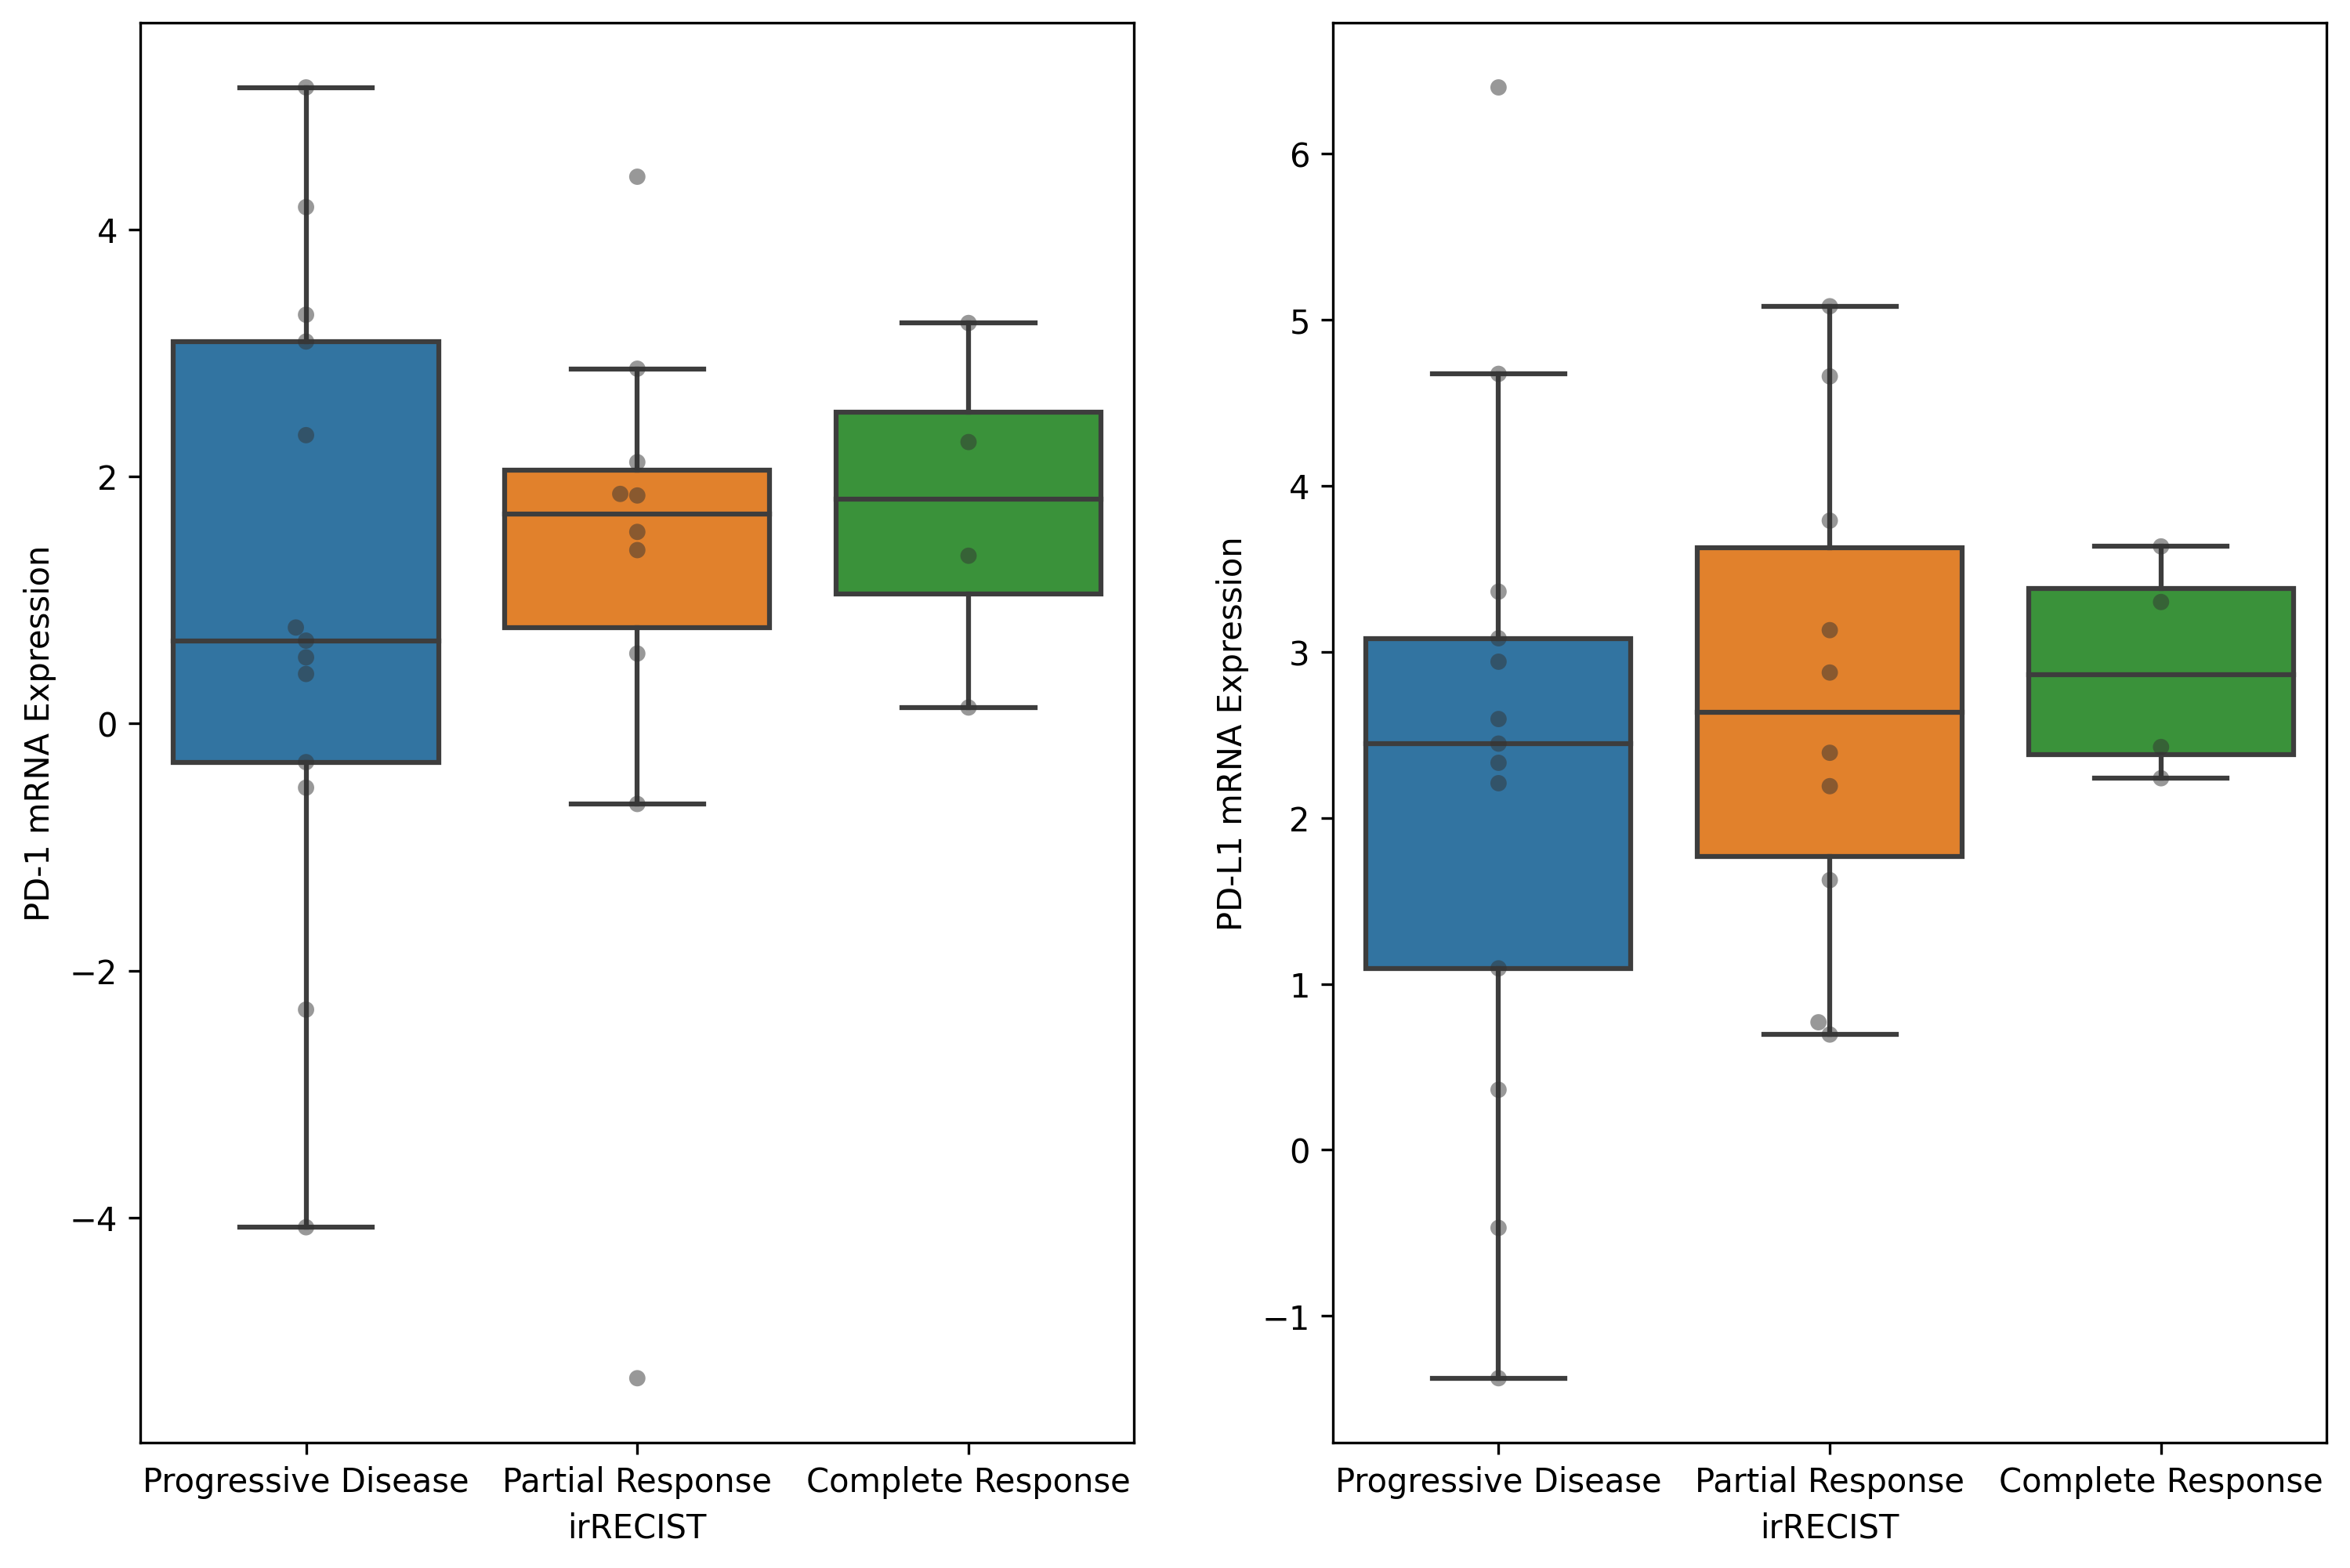

In [ ]:
#============================================================================
# Draw two box plots showing the distribution of PD-1 / PD-L1 mRNA expression
# levels in responding group and non-responding group respectively
#============================================================================

fig, axarr = plt.subplots(1, 2, dpi=300, figsize=(12, 8))

sns.boxplot(x="irRECIST", y="PDCD1", data=pd1, order=["Progressive Disease", "Partial Response", "Complete Response"], fliersize=0, ax=axarr[0])
sns.swarmplot(x="irRECIST", y="PDCD1", data=pd1, order=["Progressive Disease", "Partial Response", "Complete Response"], color=".2", alpha=0.5, ax=axarr[0])
axarr[0].set_ylabel("PD-1 mRNA Expression")
sns.boxplot(x="irRECIST", y="CD274", data=pd1, order=["Progressive Disease", "Partial Response", "Complete Response"], fliersize=0, ax=axarr[1])
sns.swarmplot(x="irRECIST", y="CD274", data=pd1, order=["Progressive Disease", "Partial Response", "Complete Response"], color=".2", alpha=0.5, ax=axarr[1])
axarr[1].set_ylabel("PD-L1 mRNA Expression")

### Answer the following questions:

#### 2.1 Comparing the p-values of the Mann-Whitney u test comparing PD-1 mRNA expresion levels in responders vs. non-responders, and PD-L1 mRNA expression levels in responders vs. non-responders with the paper:

The p values found through Mann-Whitney U tests here were similar to the results from the paper, as the authors there noted that statistical significance cutoffs were not met with P = 0.3 (somewhat close to what was achieved here), saying that "responding pretreatment tumors on anti-PD-1 therapy harbored more non-synonymous single nucleotide variants (nsSNVs) compared to the non-responding tumors."


### Association between TMB and response

Next here I investigate the association between tumor mutation burden (TMB) and the response. As we did in the class, I define the TMB of a sample to be the total mutation count.



In [ ]:
mut_file = DATA / "skcm_gse78220_mutations.txt"

# load mutation
mut = pd.read_csv(mut_file, "\t")

mut = mut.rename(columns={"Sample": "PatientID"})

mut.head()

,Chr,Pos,NucMut,PatientID,Gene,Transcript,Detail,MutType,Aamut,CodonChange,cDNAmut,ConsvScr,Database,NumCall,MUTECT,HapCaller,VarScan2
0,chr10,52573694,C>T,Pt1,A1CF,uc001jjj.3;ENST00000373993.1;NA,APOBEC1 complementation factor,Missense_Mutation,D424N,c.(1270-1272)Gac>Aac,c.1270G>A,GERP|0.94306;PolyP|0.69078|D:D:P:D;SIFT|T|0.52...,COSMIC|n=29|NA,3,"Pt1:C/T:(119,20)|Pt1.normal:C/C:(174,0):52.365604","Pt1:C/T:(122,20)|Pt1.normal:C/C:(155,0):1.8410...","Pt1:C/T:(122,19):13.48%|Pt1.normal:C/C:(185,0)..."
1,chr3,151545418,C>T,Pt1,AADAC,uc003eze.3;ENST00000232892.7;NM_001086.2,arylacetamide deacetylase,Missense_Mutation,P220S,c.(658-660)Cct>Tct,c.658C>T,GERP|0.61882;PolyP|0.76494|D;SIFT|D|0.66056;Si...,COSMIC|n=19|NA,3,"Pt1:C/T:(64,68)|Pt1.normal:C/C:(152,1):42.591359","Pt1:C/T:(69,71)|Pt1.normal:C/C:(92,0):1.436159...","Pt1:C/T:(68,69):50.36%|Pt1.normal:C/C:(154,1):..."
2,chr2,215854291,C>T,Pt1,ABCA12,uc002vew.3;ENST00000272895.7;NM_173076.2,"ATP-binding cassette, sub-family A (ABC1), mem...",Missense_Mutation,E1227K,c.(3679-3681)Gaa>Aaa,c.3679G>A,GERP|0.75309;PolyP|0.89917|D:D;SIFT|D|0.87932;...,COSMIC|n=139|NA,3,"Pt1:C/T:(122,65)|Pt1.normal:C/C:(138,0):41.472231","Pt1:C/T:(123,67)|Pt1.normal:C/C:(86,0):1.44046...","Pt1:C/T:(125,64):33.86%|Pt1.normal:C/C:(139,0)..."
3,chr7,48313899,C>T,Pt1,ABCA13,uc003toq.2;ENST00000435803.1;NM_152701.3,"ATP-binding cassette, sub-family A (ABC1), mem...",Missense_Mutation,H1546Y,c.(4636-4638)Cat>Tat,c.4636C>T,GERP|0.39498;PolyP|0.55385|D;SIFT|.|.;SiPhy29w...,COSMIC|n=270|NA,3,"Pt1:C/T:(120,43)|Pt1.normal:C/C:(107,1):28.925463","Pt1:C/T:(125,44)|Pt1.normal:C/C:(115,1):1.6194...","Pt1:C/T:(123,41):25%|Pt1.normal:C/C:(114,1):6...."
4,chr1,94481326,G>A,Pt1,ABCA4,uc001dqh.3;ENST00000370225.3;NM_000350.2,"ATP-binding cassette, sub-family A (ABC1), mem...",Missense_Mutation,P1761S,c.(5281-5283)Cct>Tct,c.5281C>T,GERP|0.66335;PolyP|0.60575|D:D;SIFT|D|0.66056;...,"DBSNP|rs61753027,rs62646874;COSMIC|n=147|NA",3,"Pt1:G/A:(104,16)|Pt1.normal:G/G:(150,0):45.133848","Pt1:G/A:(101,18)|Pt1.normal:G/G:(71,0):0.00013...","Pt1:G/A:(103,18):14.88%|Pt1.normal:G/G:(157,0)..."


In [ ]:
tmb = mut.groupby("PatientID").size()

In [ ]:
clin_file.head()

,PatientID,irRECIST,Study site,Gender,Age,Disease Status,Overall Survival,Vital Status,Previous MAPKi,Anatomical Location,BRAF,NRAS,NF1,Treatment,Biopsy Time,WES,RNAseq,"SRA Run ID, tumor WES","SRA Run ID, normal WES","AccessionID, WES",tumorRNA_RunID,"Accession ID, RNAseq"
0,Pt1,Progressive Disease,UCLA,F,66,M1b,607.0,Dead,N,"L post. Thigh, inf., SC",-,Q61L,NaN,Pembrolizumab,pre-treatment,1,1,SRR3083866,SRR3083867,SRP067938+,SRR3184279,GSE78220
1,Pt2,Partial Response,UCLA,M,55,M1c,927.0,Alive,N,Lung,-,-,"Frame_Shift_Ins H31fs, Splice_Site",Pembrolizumab,pre-treatment,1,1,SRR3083839,SRR3083840,SRP067938+,SRR3184280,GSE78220
2,Pt3,Partial Response,UCLA,M,58,M1c,691.0,Dead,N,Bowel,V600K,-,E572K,Pembrolizumab,pre-treatment,1,0,SRR3083841,SRR3083842,SRP067938+,NaN,NaN
3,Pt4,Partial Response,UCLA,M,62,M1c,948.0,Alive,Y,Adrenal,L331F,-,S2597*,Pembrolizumab,pre-treatment,1,1,SRR3083837,SRR3083838,SRP067938+,SRR3184281,GSE78220
4,Pt5,Partial Response,UCLA,M,61,M1c,439.0,Alive,N,"L Chestwall, SC",V600E,-,-,Pembrolizumab,pre-treatment,1,1,SRR3083857,SRR3083858,SRP067938+,SRR3184282,GSE78220


In [ ]:
# merge tmb with clinical data
mat = pd.concat([
    clin_file[["PatientID", "irRECIST"]].set_index("PatientID"),
    tmb
], axis=1, join="inner").rename(columns={0: "tmb"})

In [ ]:
#=========================================================================
# Perform Mann-Whitney U test comparing the TMB between the responders and
# non-responders
#=========================================================================
mannwhitneyu(mat.loc[mat.irRECIST.isin(["Partial Response", "Complete Response"]), "tmb"],
             mat.loc[mat.irRECIST.isin(["Progressive Disease"]), "tmb"])


MannwhitneyuResult(statistic=139.0, pvalue=0.12608772833771026)

Also create the boxplot visualization

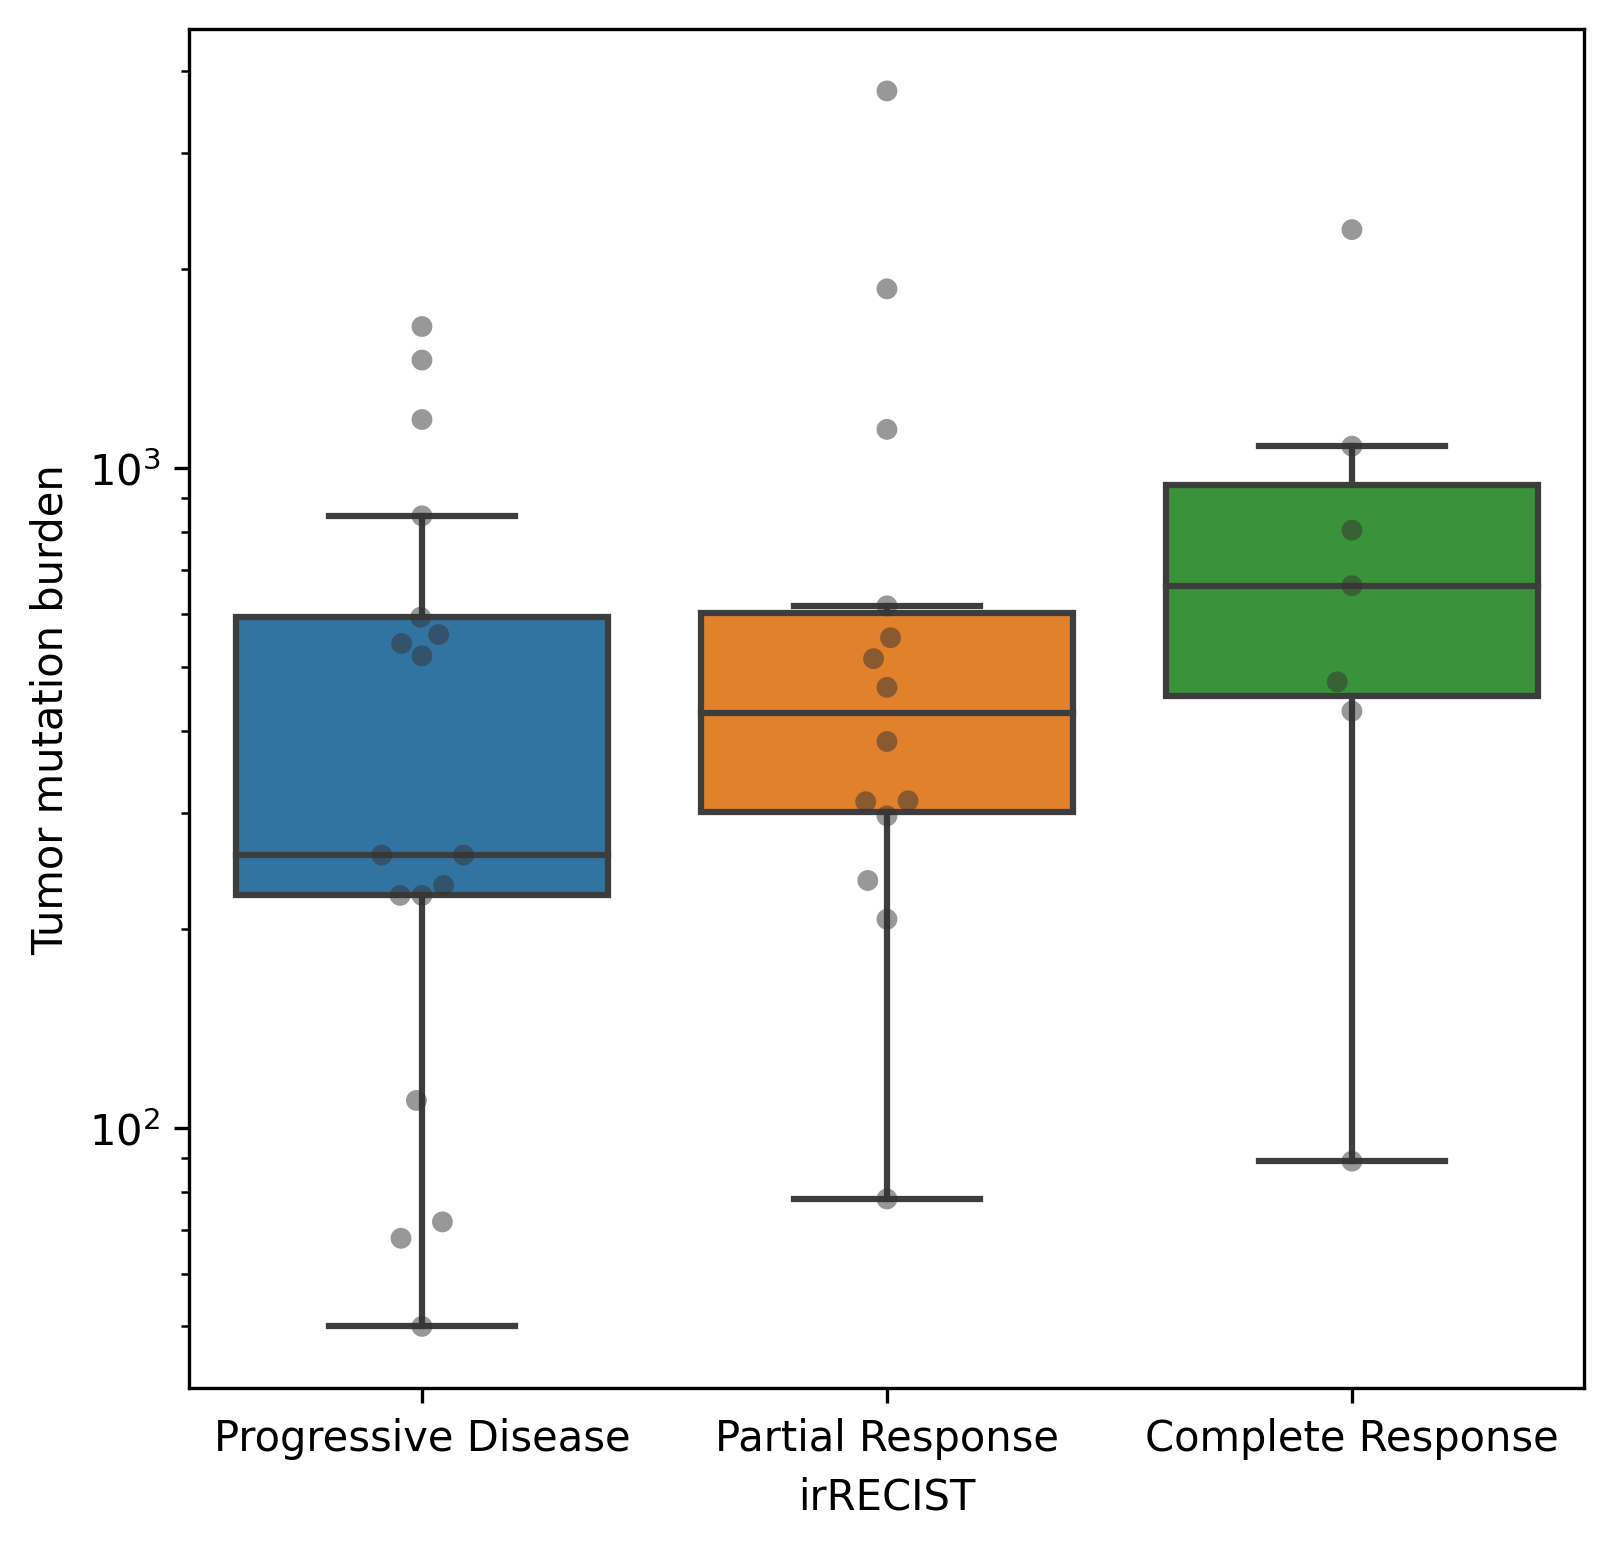

In [ ]:
#=========================================================================
# Draw a box plot showing the distribution of TMBs in responding group and
# non-responding group respectively
#=========================================================================
fig, ax = plt.subplots(dpi=300, figsize=(6, 6))

sns.boxplot(x="irRECIST", y="tmb", data=mat, order=["Progressive Disease", "Partial Response", "Complete Response"], fliersize=0, ax=ax)
sns.swarmplot(x="irRECIST", y="tmb", data=mat, order=["Progressive Disease", "Partial Response", "Complete Response"], color=".2", alpha=0.5, ax=ax)
ax.set_ylabel("Tumor mutation burden")
ax.set_yscale("log")

#### 2.2 Objective determination of the p-value from the Mann-Whitney U test for signficant association:

The p-value between the two groups was 0.126, indicating that the association between TMB and response is not significant in this data set.


## 2.3: In this problem, I attempt to recreate the analysis of [Figure 1D](https://www.sciencedirect.com/science/article/pii/S009286741630215X?via%3Dihub#fig1) of the Hugo _et al._ paper. They divide the patients in to 4 groups: 

1. High-TMB responders: Responding patients with TMB greater than the median TMB of the responding group
2. Low-TMB responders: Responding patients with TMB fewer than or equal to the median TMB of the responding group
3. High-TMB non-responders: Non-responding patients with TMB greater than the median TMB of the non-responding group
4. Low-TMB non-responders: Non-responding patients with TMB fewer than or equal to than the median TMB of the non-responding group

Here, I draw a Kaplan-Meier plot depicting the overall survival rate of these four groups, and perform statistical test comparing group 2 vs 3, group 1 vs 4, respectively using Cox proportional hazard model. The overall survival information is included in the columns `Overall Survival` and `Vital Status`



In [ ]:
mat.head()

,irRECIST,tmb
PatientID,,
Pt1,Progressive Disease,1638
Pt2,Partial Response,1868
Pt3,Partial Response,1144
Pt4,Partial Response,3727
Pt5,Partial Response,312


In [ ]:
clin.head()

,Patient ID,irRECIST,Study site,Gender,Age,Disease Status,Overall Survival,Vital Status,Previous MAPKi,Anatomical Location,BRAF,NRAS,NF1,Treatment,Biopsy Time,WES,RNAseq,"SRA Run ID, tumor WES","SRA Run ID, normal WES","AccessionID, WES","SRA Run ID, tumor RNA","Accession ID, RNAseq"
0,Pt1,Progressive Disease,UCLA,F,66,M1b,607.0,Dead,N,"L post. Thigh, inf., SC",-,Q61L,NaN,Pembrolizumab,pre-treatment,1,1,SRR3083866,SRR3083867,SRP067938+,SRR3184279,GSE78220
1,Pt2,Partial Response,UCLA,M,55,M1c,927.0,Alive,N,Lung,-,-,"Frame_Shift_Ins H31fs, Splice_Site",Pembrolizumab,pre-treatment,1,1,SRR3083839,SRR3083840,SRP067938+,SRR3184280,GSE78220
2,Pt3,Partial Response,UCLA,M,58,M1c,691.0,Dead,N,Bowel,V600K,-,E572K,Pembrolizumab,pre-treatment,1,0,SRR3083841,SRR3083842,SRP067938+,NaN,NaN
3,Pt4,Partial Response,UCLA,M,62,M1c,948.0,Alive,Y,Adrenal,L331F,-,S2597*,Pembrolizumab,pre-treatment,1,1,SRR3083837,SRR3083838,SRP067938+,SRR3184281,GSE78220
4,Pt5,Partial Response,UCLA,M,61,M1c,439.0,Alive,N,"L Chestwall, SC",V600E,-,-,Pembrolizumab,pre-treatment,1,1,SRR3083857,SRR3083858,SRP067938+,SRR3184282,GSE78220


In [ ]:
#@title Install required packages
!pip install lifelines

     |████████████████████████████████| 348kB 7.1MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=6bb74597020f31575e9e6d6cc1fa7a0a7ce2a728f6457d627978bad42026c31d
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [ ]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [ ]:
mat2 = clin_file[["PatientID", "irRECIST", "Vital Status"]].copy()

In [ ]:
mat_change = mat2.replace("Dead", 0)

In [ ]:
mat_test = mat_change.replace("Alive", 1)

In [ ]:
mat_fin = pd.concat([
    mat_test.set_index("PatientID"),
    tmb
], axis=1, join="inner").rename(columns={0: "tmb"})

In [ ]:
mat_fin.head()

,irRECIST,tmb,Vital_Event
PatientID,,,
Pt1,Progressive Disease,1638,1
Pt2,Partial Response,1868,0
Pt3,Partial Response,1144,1
Pt4,Partial Response,3727,0
Pt5,Partial Response,312,0


In [ ]:
mat_fin["Vital_Event"] = 1 - mat_fin["Vital Status"]
mat_fin.drop(["Vital Status"], axis=1, inplace=True)

In [ ]:
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(dpi=300, figsize=(5, 5))

tmb_high_idx = mat_fin.tmb >= mat_fin.tmb.median()

kmf.fit(mat_fin.irRECIST[tmb_high_idx], mat_fin.Vital_Event[tmb_high_idx],
        label="TMB_high")
kmf.plot(ax=ax, show_censors=True)
kmf.fit(mat.irRECIST[~tmb_high_idx], mat_fin.Vital_Event[~tmb_high_idx],
        label="TMB_low")
kmf.plot(ax=ax, show_censors=True)